In [ ]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import glob
import tensorflow as tf
import re
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,Layer,LayerNormalization,ReLU,MaxPooling2D,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [ ]:
normal_dir = r"/content/drive/MyDrive/finally_done/Normal"
extensions = ["*.png", "*.jpeg", "*.jpg"]
normal_files = []
for ext in extensions:
    """Join the directory path with each extension and using glob.glob() to find matching files which are then
    appended to normal_files list"""
    normal_files.extend(glob.glob(os.path.join(normal_dir, ext)))

In [ ]:
pneumonia_dir = r"/content/drive/MyDrive/finally_done/Pneumonia"
extensions = ["*.png", "*.jpeg", "*.jpg"]
pneumonia_files = []
for ext in extensions:
    pneumonia_files.extend(glob.glob(os.path.join(pneumonia_dir, ext)))

In [ ]:
covid_dir = r"/content/drive/MyDrive/finally_done/Covid"
extensions = ["*.png", "*.jpeg", "*.jpg"]
covid_files = []
for ext in extensions:
    covid_files.extend(glob.glob(os.path.join(covid_dir, ext)))

In [ ]:
normal_files.sort()
covid_files.sort()
pneumonia_files.sort()

In [ ]:
# ~75% of each category is used in the training set
file_lists = [covid_files[:900], normal_files[:900], pneumonia_files[:900]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
train_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}

In [ ]:
import random
# In-place shuffling of training set with 3 as the seed of the random number generator
l = list(train_dic.items())
random.Random(3).shuffle(l)


In [ ]:
print(len(l))

2700


In [ ]:
data = []
labels = []
for f,label in l:
  img = cv2.imread(f)
  img = img.astype('float32')/255.0 # Normalize the image
  data.append(img)
  labels.append(label)

train_data = np.array(data)
train_labels = np.array(labels)
print(train_data.shape)
print(train_labels.shape)
print('Training set preparation completed')

(2700, 224, 224, 3)
(2700, 3)
Training set preparation completed


In [ ]:
Densenet_model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',classes = 3)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
Densenet_model.trainable = False

In [ ]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = Densenet_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)

y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

# Add a Dropout layer
flat = Dropout(0.12)(flat)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
Densenet_pred = Model(inputs = inputs,outputs = prediction)

In [ ]:
Densenet_pred.summary()
Densenet_pred.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, None, None, 1024)     7037504   ['input_2[0][0]']             
                                                                                                  
 expand_dims_layer (ExpandD  (None, 1, 7, 7, 1024)        0         ['densenet121[0][0]']         
 imsLayer)                                                                                        
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 7, 7, 512)            3147776   ['expand_dims_layer[0][0]'

In [ ]:
Dense_history = Densenet_pred.fit(train_data,train_labels,epochs = 10)

Epoch 1/10
85/85 [==============================] - 32s 158ms/step - loss: 1.0297 - accuracy: 0.8533 - precision: 0.8695 - recall: 0.8389
Epoch 2/10
85/85 [==============================] - 11s 124ms/step - loss: 0.1411 - accuracy: 0.9515 - precision: 0.9532 - recall: 0.9500
Epoch 3/10
85/85 [==============================] - 11s 125ms/step - loss: 0.0620 - accuracy: 0.9763 - precision: 0.9777 - recall: 0.9756
Epoch 4/10
85/85 [==============================] - 11s 125ms/step - loss: 0.0364 - accuracy: 0.9863 - precision: 0.9863 - recall: 0.9863
Epoch 5/10
85/85 [==============================] - 11s 127ms/step - loss: 0.0163 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9944
Epoch 6/10
85/85 [==============================] - 11s 128ms/step - loss: 0.0191 - accuracy: 0.9933 - precision: 0.9933 - recall: 0.9933
Epoch 7/10
85/85 [==============================] - 11s 128ms/step - loss: 0.0124 - accuracy: 0.9967 - precision: 0.9967 - recall: 0.9967
Epoch 8/10
85/85 [================

In [ ]:
# Save the weights
Densenet_pred.save('/content/drive/MyDrive/Models/Densenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


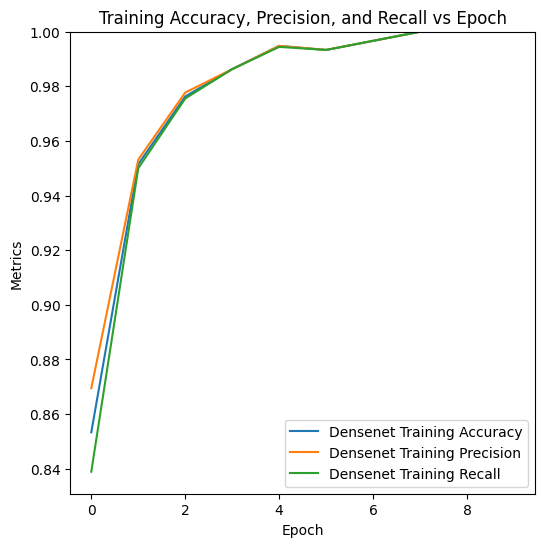

In [ ]:
acc = Dense_history.history['accuracy']
prec = Dense_history.history['precision']
recall = Dense_history.history['recall']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='Densenet Training Accuracy')

# Plotting Precision
plt.plot( prec, label='Densenet Training Precision')

# Plotting Recall
plt.plot( recall, label='Densenet Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [ ]:
vgg_model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',classes = 3)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg_model.trainable = False

In [ ]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = vgg_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)

#x_add = Add()([x1,x3])
y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

# Add a Dropout layer
flat = Dropout(0.12)(flat)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
vgg_pred = Model(inputs = inputs,outputs = prediction)

In [ ]:
vgg_pred.summary()
vgg_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, None, None, 512)      2002438   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 expand_dims_layer_1 (Expan  (None, 1, 7, 7, 512)         0         ['vgg19[0][0]']               
 dDimsLayer)                                                                                      
                                                                                            

In [ ]:
vgg_history = vgg_pred.fit(train_data,train_labels,epochs = 10)

Epoch 1/10
85/85 [==============================] - 30s 225ms/step - loss: 1.0242 - accuracy: 0.8389 - precision_1: 0.8523 - recall_1: 0.8274
Epoch 2/10
85/85 [==============================] - 16s 192ms/step - loss: 0.1676 - accuracy: 0.9407 - precision_1: 0.9417 - recall_1: 0.9385
Epoch 3/10
85/85 [==============================] - 16s 189ms/step - loss: 0.0968 - accuracy: 0.9678 - precision_1: 0.9688 - recall_1: 0.9670
Epoch 4/10
85/85 [==============================] - 16s 185ms/step - loss: 0.0493 - accuracy: 0.9841 - precision_1: 0.9841 - recall_1: 0.9837
Epoch 5/10
85/85 [==============================] - 16s 184ms/step - loss: 0.0558 - accuracy: 0.9826 - precision_1: 0.9826 - recall_1: 0.9826
Epoch 6/10
85/85 [==============================] - 16s 184ms/step - loss: 0.0139 - accuracy: 0.9963 - precision_1: 0.9963 - recall_1: 0.9963
Epoch 7/10
85/85 [==============================] - 16s 186ms/step - loss: 0.0271 - accuracy: 0.9941 - precision_1: 0.9941 - recall_1: 0.9941
Epoch 

In [ ]:
# Save the weights
vgg_pred.save('/content/drive/MyDrive/Models/vgg.h5')

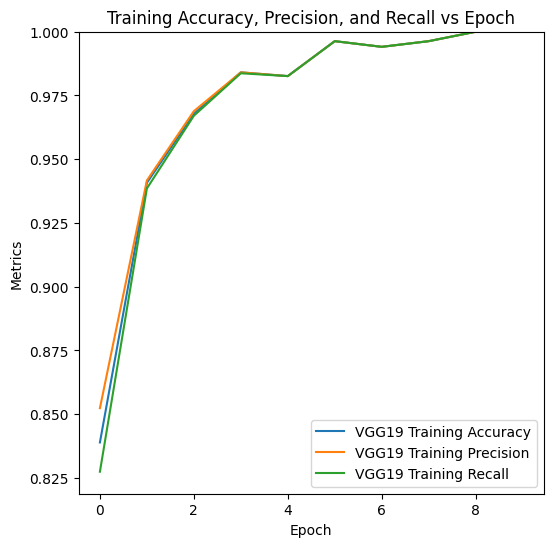

In [ ]:
acc = vgg_history.history['accuracy']
prec = vgg_history.history['precision_1']
recall = vgg_history.history['recall_1']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='VGG19 Training Accuracy')

# Plotting Precision
plt.plot( prec, label='VGG19 Training Precision')

# Plotting Recall
plt.plot( recall, label='VGG19 Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [ ]:
mobile_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),include_top=False,weights='imagenet',classes = 3)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_model.trainable = False

In [ ]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = mobile_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)


y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

# Add a Dropout layer
flat = Dropout(0.12)(flat)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
mobile_pred = Model(inputs = inputs,outputs = prediction)

In [ ]:
mobile_pred.summary()
mobile_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_6[0][0]']             
 onal)                                                                                            
                                                                                                  
 expand_dims_layer_2 (Expan  (None, 1, 7, 7, 1024)        0         ['mobilenet_1.00_224[0][0]']  
 dDimsLayer)                                                                                      
                                                                                            

In [ ]:
mobile_history = mobile_pred.fit(train_data,train_labels,epochs = 10)

Epoch 1/10
85/85 [==============================] - 12s 81ms/step - loss: 0.3119 - accuracy: 0.8800 - precision_2: 0.8960 - recall_2: 0.8652
Epoch 2/10
85/85 [==============================] - 6s 75ms/step - loss: 0.0801 - accuracy: 0.9719 - precision_2: 0.9733 - recall_2: 0.9707
Epoch 3/10
85/85 [==============================] - 6s 76ms/step - loss: 0.0287 - accuracy: 0.9937 - precision_2: 0.9937 - recall_2: 0.9937
Epoch 4/10
85/85 [==============================] - 6s 74ms/step - loss: 0.0135 - accuracy: 0.9978 - precision_2: 0.9978 - recall_2: 0.9974
Epoch 5/10
85/85 [==============================] - 7s 77ms/step - loss: 0.0036 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 6/10
85/85 [==============================] - 6s 74ms/step - loss: 0.0021 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 7/10
85/85 [==============================] - 7s 77ms/step - loss: 0.0012 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 8/10
85/85 [=

In [ ]:
# Save the weights
mobile_pred.save('/content/drive/MyDrive/Models/mobile.h5')

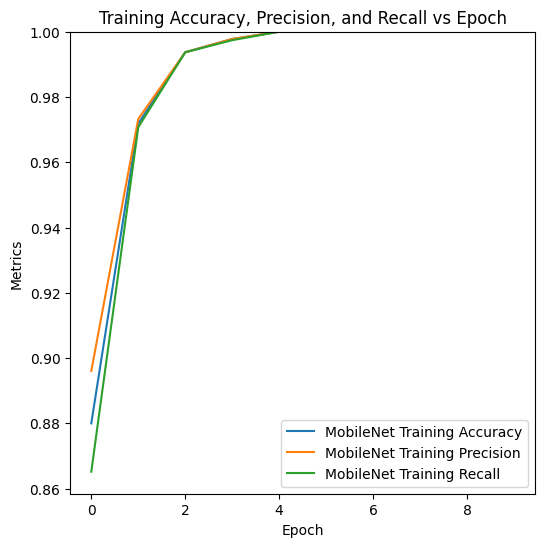

In [ ]:
acc = mobile_history.history['accuracy']
prec = mobile_history.history['precision_2']
recall = mobile_history.history['recall_2']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='MobileNet Training Accuracy')

# Plotting Precision
plt.plot( prec, label='MobileNet Training Precision')

# Plotting Recall
plt.plot( recall, label='MobileNet Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet')


94668760/94668760 [==============================] - 2s 0us/step


In [ ]:
resnet_model.trainable = False


In [ ]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
inputs = tf.keras.Input(shape=(224,224,3))
x = resnet_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)

y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

# Add a Dropout layer
flat = Dropout(0.12)(flat)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
resnet_pred = Model(inputs = inputs,outputs = prediction)

In [ ]:
resnet_pred.summary()
resnet_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50v2 (Functional)     (None, None, None, 2048)     2356480   ['input_8[0][0]']             
                                                          0                                       
                                                                                                  
 expand_dims_layer_3 (Expan  (None, 1, 7, 7, 2048)        0         ['resnet50v2[0][0]']          
 dDimsLayer)                                                                                      
                                                                                            

In [ ]:
res_history = resnet_pred.fit(train_data,train_labels,epochs = 10)

Epoch 1/10
85/85 [==============================] - 23s 146ms/step - loss: 0.8619 - accuracy: 0.8585 - precision_3: 0.8720 - recall_3: 0.8474
Epoch 2/10
85/85 [==============================] - 11s 131ms/step - loss: 0.1100 - accuracy: 0.9663 - precision_3: 0.9676 - recall_3: 0.9630
Epoch 3/10
85/85 [==============================] - 11s 131ms/step - loss: 0.0474 - accuracy: 0.9844 - precision_3: 0.9848 - recall_3: 0.9841
Epoch 4/10
85/85 [==============================] - 11s 131ms/step - loss: 0.0081 - accuracy: 0.9974 - precision_3: 0.9974 - recall_3: 0.9970
Epoch 5/10
85/85 [==============================] - 11s 130ms/step - loss: 0.0087 - accuracy: 0.9974 - precision_3: 0.9978 - recall_3: 0.9974
Epoch 6/10
85/85 [==============================] - 11s 129ms/step - loss: 0.0015 - accuracy: 0.9996 - precision_3: 0.9996 - recall_3: 0.9996
Epoch 7/10
85/85 [==============================] - 11s 130ms/step - loss: 8.7319e-05 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000
Ep

In [ ]:
# Save the weights
resnet_pred.save('/content/drive/MyDrive/Models/resnet.h5')

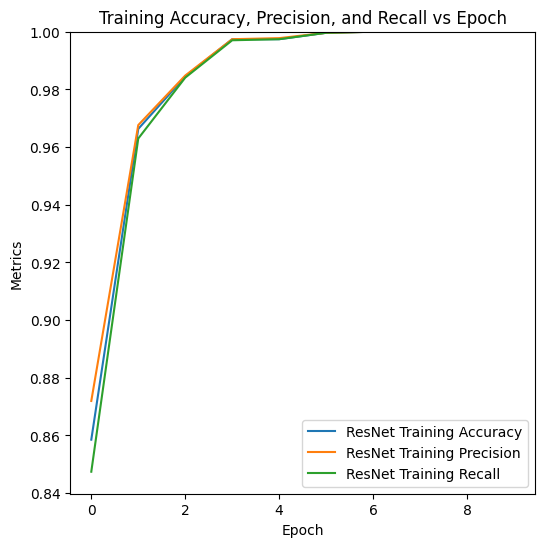

In [ ]:
acc = res_history.history['accuracy']
prec = res_history.history['precision_3']
recall = res_history.history['recall_3']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='ResNet Training Accuracy')

# Plotting Precision
plt.plot( prec, label='ResNet Training Precision')

# Plotting Recall
plt.plot( recall, label='ResNet Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()